## Загрузка библиотек

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

## Загрузка данных

In [27]:
# Обозначим путь к папкам

train_dataset_path = 'D:/Skillfactory/Practice/Python/NN/CV_project1_data/data/train'
test_dataset_path = 'D:/Skillfactory/Practice/Python/NN/CV_project1_data/data/valid'

In [28]:
# Выполним необходимые преобразования для будущих загрузок

train_transforms = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.ToTensor()
])

In [29]:
# Используем функцию PyTorch ImageFolder для создания наборов данных

train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)

In [5]:
classes = train_dataset.classes

In [6]:
# Создадим функцию для отрисовки одного батча изображений, состоящего из
# шести изображений. Данные загружаются с помощью функции DataLoader

def show_transformed_images(dataset):
    loader = DataLoader(dataset, batch_size=6, shuffle=True)
    images, labels = next(iter(loader))

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('classes: ', [classes[i] for i in labels])

classes:  ['jeff_bezos', 'steve_jobs', 'steve_jobs', 'elon_musk', 'elon_musk', 'elon_musk']


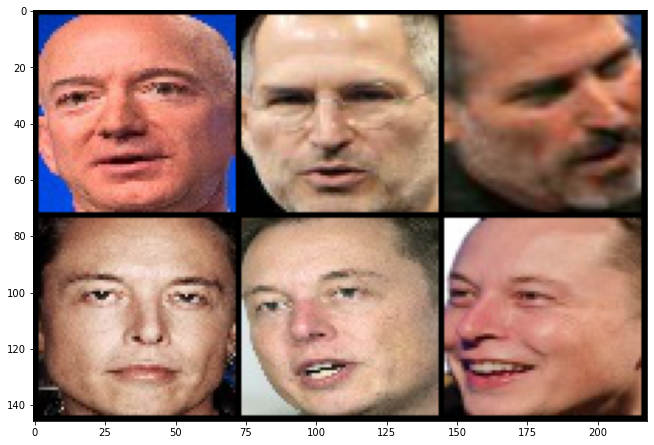

In [7]:
show_transformed_images(train_dataset)

In [8]:
# Загрузим данные в train и test

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

## Обучение модели

In [10]:
# Создадим функцию для обучения модели

def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    
    # на каждой эпохе происходит обучение и валидация
    for epochs in range(n_epochs):
        print("Epochs number %d " % (epochs + 1)) 
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            total += labels.size(0)
            optimizer.zero_grad()
            
            # получаем прогноз модели и считаем потери
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # считаем значения статистик
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print(" ... Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))

        evaluate_model_on_test_set(model, test_loader)

    print("Finished")
    return model

In [11]:
# Создадим функцию для оценки созанной модели

def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            total += labels.size(0)         
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    # считаем точность предсказания модели
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    
    print(" ... Testing dataset. Got %d out of %d images correctly (%.3f%%)"
          % (predicted_correctly_on_epoch, total, epoch_acc))

In [12]:
# Будем использовать ResNet34 в качестве предобученной модели

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet34_model = models.resnet34(pretrained=True)
num_ftrs = resnet34_model.fc.in_features
number_of_classes = 5
resnet34_model.fc = nn.Linear(num_ftrs, number_of_classes)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet34_model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.003)

In [13]:
# Обучим предоьученную модель ResNet34 на 20 эпохах

classification_result = train_nn(resnet34_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=20)

Epochs number 1 
 ... Training dataset. Got 2419 out of 3000 images correctly (80.633%). Epoch loss: 0.654
 ... Testing dataset. Got 739 out of 914 images correctly (80.853%)
Epochs number 2 
 ... Training dataset. Got 2888 out of 3000 images correctly (96.267%). Epoch loss: 0.126
 ... Testing dataset. Got 881 out of 914 images correctly (96.389%)
Epochs number 3 
 ... Training dataset. Got 2928 out of 3000 images correctly (97.600%). Epoch loss: 0.081
 ... Testing dataset. Got 831 out of 914 images correctly (90.919%)
Epochs number 4 
 ... Training dataset. Got 2939 out of 3000 images correctly (97.967%). Epoch loss: 0.072
 ... Testing dataset. Got 903 out of 914 images correctly (98.796%)
Epochs number 5 
 ... Training dataset. Got 2975 out of 3000 images correctly (99.167%). Epoch loss: 0.031
 ... Testing dataset. Got 906 out of 914 images correctly (99.125%)
Epochs number 6 
 ... Training dataset. Got 2980 out of 3000 images correctly (99.333%). Epoch loss: 0.019
 ... Testing datas

Наилучшими оказались результаты на 9 эпохе: точность предсказания 99.7% на тренировочной выборке и 99.562% на тестовой выборке. Потери на этой эпохе составляют 0.011.

## Визуализация модели

In [30]:
# Создадим функцию для визуализации модели

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

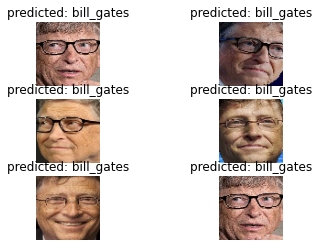

In [32]:
# Посмотрим, как работает модель на наших данных

visualize_model(classification_result)

Основной целью было добиться accuracy > 0.85 на валидационной выборке. В данном случае построении модели точность составила 99.562%. Для этого была использована предобученная модель ResNet34, которая обучалась на 20 эпохах. Данные были загружены с помощью DataLoader. Визуализация результатов показала, что модель работает корректно.  